In [0]:
import torch
from torchvision import transforms

### Подготовка данных

In [0]:
from torchvision.datasets import MNIST

In [0]:
_tasks = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [0]:
## Load MNIST Dataset and apply transformations
mnist = MNIST('./MNIST_data', download=True, train=True, transform=_tasks)

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
## create training and validation split 
split = int(0.8 * len(mnist))
index_list = list(range(len(mnist)))
train_idx, valid_idx = index_list[:split], index_list[split:]

In [0]:
## create sampler objects using SubsetRandomSampler
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

In [0]:
## create iterator objects for train and valid datasets
batch_size = 50
trainloader = DataLoader(mnist, batch_size=batch_size, sampler=tr_sampler)
validloader = DataLoader(mnist, batch_size=batch_size, sampler=val_sampler)

### Задаем архитектуру нейросети

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets

import numpy as np

%matplotlib inline

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Связь между параметрами свертки и шириной входного/выходного изображения:

$$W_{out} = \frac{(W_{in} - K + 2P)}{S} + 1$$

где $W_{int}$ - ширина входа, $K$ - размер ядра, $P$ - padding, $S$ - шаг

Источник: https://neurohive.io/ru/tutorial/cnn-na-pytorch/ 

In [0]:
class Interpolate(nn.Module):
    """Обертка для nn.functional.interpolate, чтобы ее можно было использовать в nn.Sequential.
    А все потому, что 'nn.Upsample is deprecated'
    """
    def __init__(self, size=None, scale_factor=None, mode='nearest', align_corners=None):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        self.scale_factor = scale_factor
        self.align_corners = align_corners
        
    def forward(self, x):
        x = self.interp(x, size=self.size, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners)
        return x

In [0]:
class Encoder(nn.Module):
    """ подсеть кодировщик """
    def __init__(self):
        super().__init__()
        
        # сверточные слои
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) 
        # => матрицы 14x14
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) 
        # => матрицы 7x7
    
    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer2(x) 
        return x
    
class Decoder(nn.Module):
    """ сеть декодировщик """
    def __init__(self):
        super().__init__()        
        
        # сверточные слои
        self.layer1 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),            
            #nn.Upsample(scale_factor=2, mode='nearest')
            Interpolate(scale_factor=2, mode='nearest')
        ) 
        # => матрицы 14x14
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),            
            #nn.Upsample(scale_factor=2, mode='nearest')
            Interpolate(scale_factor=2, mode='nearest')
        ) 
        # => матрицы 28x28
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),                        
        ) 
        # => матрицы 28x28
    
    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer2(x) 
        x = self.layer3(x) 
        return x

In [0]:
class Net(nn.Module):
    """ сеть кодировщик+декодировщик """
    def __init__(self, name="ae"):
        super().__init__()
        
        self.name = name        
        self.E = Encoder()
        self.D = Decoder()
                
        self.optim = optim.Adam(self.parameters(), lr=1e-4)
        self._loss = nn.MSELoss()
        
    def forward(self, x):                
        h = self.E(x)        
        out = self.D(h)
        
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)    
    
    def loss(self, output, target):                 
        return self._loss(output, target) #F.cross_entropy(output, target) 

### Тренировка

######  несколько вспомогательных функций

In [0]:
# Строит графики динамики обучения
def show(loss_history, title):
    fig, ax1 = plt.subplots(1,1, figsize=(14,4))

    ax1.plot(loss_history['valid'], label='на проверочном наборе')
    ax1.plot(loss_history['train'], label='на обучающем наборе')
    ax1.grid()
    ax1.set_title(title)    
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Loss')
    ax1.legend()    

In [0]:
# отрисовывает в черно-белом стиле изображения из массива images,
# расставляя их по матрице формы shape
def plot_mnist(images, shape, title):
    fig = plt.figure(figsize=shape[::-1], dpi=80)    
    
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    print(title, ': ')
    plt.show()

In [0]:
# тренирует с отслеживанием показателей
def train_eval(N_epoch, model):
    print('Model %s :' % model.name)
    
    loss_history = {'train': [], 'valid': []}
    metrics_history = {'accuracy':[]}
    
    for epoch in range(1, N_epoch): # N_epoch раз прогоняем обучение-тест
        train_loss, valid_loss = [], []

        ## training part 
        model.train()
        for data, target in trainloader: # выбираем (data, target) батч за батчем
            model.optim.zero_grad()

            ## 1. forward propagation
            output = model(data)

            ## 2. loss calculation
            #rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) # + rho_loss
            
            ## 3. backward propagation
            loss.backward()

            ## 4. weight optimization
            model.optim.step()

            train_loss.append(loss.item())

        loss_history['train'].append(np.mean(train_loss))

        ## evaluation part 
        model.eval()
        for data, target in validloader:
            output = model(data)
            
            #rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) #+ rho_loss
            
            valid_loss.append(loss.item())

        loss_history['valid'].append(np.mean(valid_loss))
        
        print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Valid Loss: ", np.mean(valid_loss))
            
    return (model, loss_history)

### Создаем экземпляр модели и обучаем

In [18]:
model_autoencoder = Net(name='Convoluted Autoencoder 16-8|8-16')

models = [model_autoencoder]

# Запускаем обучение сетей
N_epochs = 11
history = []
for i, model in enumerate(models):  
      
    net, loss_history = train_eval(N_epochs,model)
    history.append({'net': net, 'loss': loss_history })

Model Convoluted Autoencoder 16-8|8-16 :
Epoch: 1 Training Loss:  0.6993176789022982 Valid Loss:  0.5468222369750341
Epoch: 2 Training Loss:  0.5296306368273993 Valid Loss:  0.5129003395636876
Epoch: 3 Training Loss:  0.5089347035624087 Valid Loss:  0.5002790222565333
Epoch: 4 Training Loss:  0.49987052492797374 Valid Loss:  0.49361275049547354
Epoch: 5 Training Loss:  0.49482068717479705 Valid Loss:  0.48957474206884705
Epoch: 6 Training Loss:  0.4916219308351477 Valid Loss:  0.4868049927055836
Epoch: 7 Training Loss:  0.48927247039973737 Valid Loss:  0.4846541843066613
Epoch: 8 Training Loss:  0.48735056081786754 Valid Loss:  0.4828113359709581
Epoch: 9 Training Loss:  0.48570879896481833 Valid Loss:  0.4813258294016123
Epoch: 10 Training Loss:  0.4843819396259884 Valid Loss:  0.4801211919635534


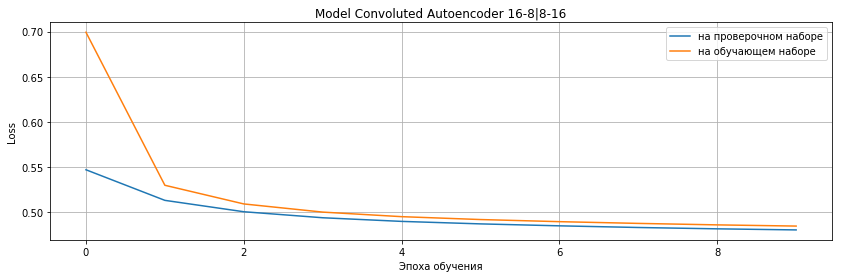

In [19]:
# Визуализируем показатели обучения
for way in history:
    show(way['loss'], 'Model ' + way['net'].name)    

In [0]:
### Посмотрим глазами на результаты обучения

In [0]:
# Возьмем 1 батч из тестового набора
data, _ = next(iter(validloader))

# Выход модели (автокодировщика) с этого батча
modelka = models[0]
output = modelka(data)

to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()


Батч из тестового набора : 


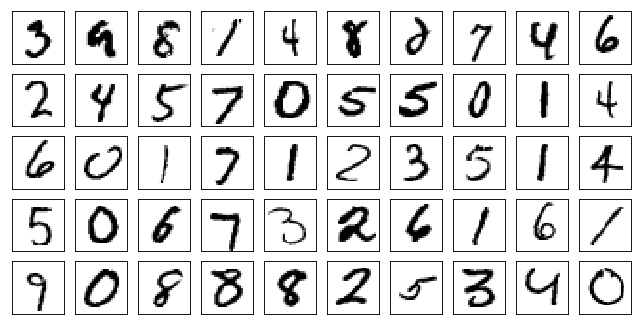

Выход сети автокодировщика : 


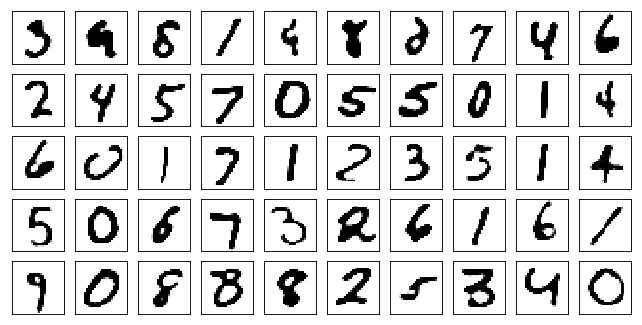

In [21]:
plot_mnist(data.data.numpy(), (5, 10), 'Батч из тестового набора')
plot_mnist(to_plot, (5, 10), 'Выход сети автокодировщика')

### Источники вдохновения

1 https://blog.keras.io/building-autoencoders-in-keras.html